# Projet NLP 
Anatole Gayant & Jules Avignon

sommaire :
Probl√©matique : Quelles sont les tendances et les th√®mes r√©currents dans les paroles de chansons d'une d√©cennie sp√©cifique ?
Donn√©es : issue de kaggle https://www.kaggle.com/datasets/deepshah16/song-lyrics-dataset/
Traitements linguistiques : Lemmatisation, extraction de bi-grams/tri-grams, suppression des stop words.
Fouille : Topic modeling, d√©tection de th√®mes r√©currents, comparaison avec d'autres d√©cennies.

Description des donn√©es : 
Nous avons maintenant un dataframe combin√© contenant 6027 chansons de diff√©rents artistes.

## 1 Pr√©paration des donn√©es

In [2]:
import csv 
import os
import zipfile
import os
import pandas as pd
import re
import numpy as np

In [3]:
# Path to the uploaded archive
archive_path = "archive.zip"
extraction_path = "extracted_data/"

# Unzipping the archive
with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Listing the extracted files
extracted_files = os.listdir(extraction_path)
# Listing the files inside the "csv" folder
csv_files_path = os.path.join(extraction_path, "csv")
csv_files = os.listdir(csv_files_path)

In [4]:
# Merging all the CSV files into a single dataframe

all_dataframes = []  # A list to store dataframes of each artist

# Looping through each CSV file and appending its content to the list
for csv_file in csv_files:
    df = pd.read_csv(os.path.join(csv_files_path, csv_file))
    all_dataframes.append(df)

# Concatenating all dataframes
combined_df = pd.concat(all_dataframes, ignore_index=True)

# Dropping the "Unnamed: 0" column
combined_df.drop(columns=["Unnamed: 0"], inplace=True)

# Displaying the first few rows after dropping the column
combined_df.head()

Artist                   Title            Album        Date  \
0  Ariana Grande          ‚Äãthank u, next    thank u, next  2018-11-03   
1  Ariana Grande                 7 rings    thank u, next  2019-01-18   
2  Ariana Grande         ‚ÄãGod is a woman        Sweetener  2018-07-13   
3  Ariana Grande            Side To Side  Dangerous Woman  2016-05-20   
4  Ariana Grande  ‚Äã‚Äãno tears left to cry        Sweetener  2018-04-20   

                                               Lyric  Year  
0  thought i'd end up with sean but he wasn't a m...  2018  
1  yeah breakfast at tiffany's and bottles of bub...  2019  
2  you you love it how i move you you love it how...  2018  
3  ariana grande  nicki minaj i've been here all ...  2016  
4  right now i'm in a state of mind i wanna be in...  2018

## 1.2 Nettoyage des donn√©es

In [5]:
#quels sont les lignes de la colonne lyric qui ne sont pas des strings

# On cr√©e une fonction qui va nous permettre de savoir si une valeur est un string ou non
def is_string(value):
    return isinstance(value, str)

# On applique la fonction √† la colonne lyric
sum(combined_df["Lyric"].apply(is_string))

5981

In [6]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

# T√©l√©chargement des ressources NLTK n√©cessaires
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

def clean_lyrics(lyrics):
    # S'assurer que les paroles sont une cha√Æne de caract√®res
    if not isinstance(lyrics, str):
        return ""
    # Suppression des caract√®res sp√©ciaux
    lyrics = re.sub(r'[^A-Za-z0-9 ]+', '', lyrics)
    # Tokenization
    tokens = word_tokenize(lyrics)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    # Suppression des mots vides
    stop_words = set(stopwords.words('english'))
    cleaned_lyrics = [word for word in lemmatized if word not in stop_words]
    return ' '.join(cleaned_lyrics)

#utilisation de la fonction clean_lyrics pour nettoyer les paroles

combined_df['Lyric'] = combined_df['Lyric'].apply(clean_lyrics)
# pour appliquer la fonction calculate_genre_percentages √† chaque ligne du dataframe il faut faire un sep entre les mots tokenis√©s
combined_df['Lyric'] = combined_df['Lyric'].apply(lambda x: x.split())

## 2 Classification des genres bas√©es sur les paroles

Nous avons trouv√© sur internet des mots associ√©es a des styles musicaux :

Ces listes repr√©sentent des g√©n√©ralisations et peuvent ne pas refl√©ter la diversit√© compl√®te des paroles au sein de chaque genre. Les mots choisis tentent de capturer des th√®mes fr√©quemment abord√©s ou des √©l√©ments stylistiques typiques de chaque genre.

In [7]:
#liste de genre musicaux et mots associ√©s
genre_keywords = {
    "Rap": ["flow", "rhyme", "beat", "freestyle", "MC", "hood", "streets", "real", "life", "game", "bars", "verse", "rhymes", "spit", "rap", "flow", "mic", "lyric", "hip-hop", "graffiti", "beatbox", "cypher"],
    "R&B": ["love", "heart", "soul", "smooth", "passion", "feel", "emotion", "baby", "night", "dance", "rhythm", "blues", "groove", "melody", "sensual", "vocal", "smooth", "soulful", "harmony", "ballad", "serenade"],
    "Pop": ["fun", "party", "dance", "love", "night", "dream", "light", "young", "happy", "together","hit", "chart", "popstar", "melodic", "catchy", "hook", "radio", "mainstream", "singalong", "chorus", "verse"],
    "Rock": ["guitar", "band", "rock", "night", "live", "freedom", "rebel", "wild", "heart", "road", "electric", "solo", "drum", "bass", "loud", "amp", "punk", "metal", "grunge", "indie", "classic"],
    "Electro": ["beat", "dance", "night", "light", "energy", "bass", "synth", "club", "DJ", "party","techno", "house", "trance", "rave", "beat", "mix", "electronic", "DJ", "synthesizer", "drum machine", "dancefloor"]
}


def calculate_genre_percentages(tokenized_lyrics, genre_keywords):
    genre_counts = {genre: 0 for genre in genre_keywords}
    total_keywords_count = 0

    # Compter les occurrences des mots cl√©s de chaque genre
    for word in tokenized_lyrics:
        for genre, keywords in genre_keywords.items():
            if word in keywords:
                genre_counts[genre] += 1
                total_keywords_count += 1
    # si a la fin de la boucle for total_keywords_count est √©gal √† 0, total_keywords_count prend la valeur 1
    if total_keywords_count == 0:
        total_keywords_count = 1

    #affiche le nombre de mots de chaque liste de mots cl√©s
    return {genre: count / total_keywords_count for genre, count in genre_counts.items()}


# appliquez la fonction calculate_genre_percentages √† chaque ligne du dataframe
combined_df['genre_percentages'] = combined_df['Lyric'].apply(lambda x: calculate_genre_percentages(x, genre_keywords))

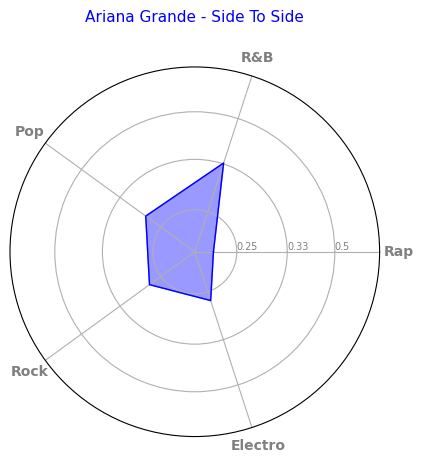

In [8]:
# fais un graphique de type radar qui montre la r√©partition des genres musicaux pour une chanson donn√©e

import matplotlib.pyplot as plt

# On cr√©e une fonction qui va nous permettre de cr√©er un graphique de type radar
def make_spider(row,artist ,title, color):
    # On cr√©e un dataframe avec les donn√©es de la ligne
    df = pd.DataFrame({
        'group': list(row.keys()),
        'values': list(row.values())
    })
    # On cr√©e un graphique de type radar
    categories = list(df['group'])
    N = len(categories)
    values = list(df['values'])
    values += values[:1]
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=10, fontweight='bold')
    ax.set_rlabel_position(0)
    plt.yticks([0.15, 0.33, 0.5], ["0.25", "0.33", "0.5"], color="grey", size=7)
    plt.ylim(0, 0.66)
    ax.plot(angles, values, color=color, linewidth=1, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    plt.title(f'{artist} - {title}', size=11, color=color, y=1.1)

# On fais le graphique pour la premi√®re ligne du dataframe
make_spider(combined_df['genre_percentages'][3], artist=combined_df['Artist'][3], title=combined_df['Title'][3], color='blue')

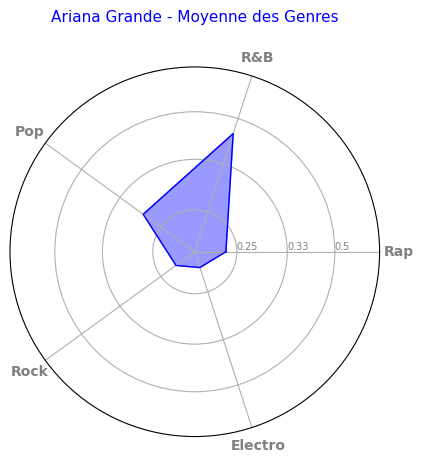

In [9]:
# cr√©e une colonne pour chaque genre avec la valeur de la r√©partition du genre pour chaque chanson
for genre in genre_keywords:
    combined_df[genre] = combined_df['genre_percentages'].apply(lambda x: x[genre])

# Calculer la moyenne des pourcentages de genre pour un artiste sp√©cifique
def calculate_average_genre_percentages(df, artist_name):
    artist_df = df[df['Artist'] == artist_name]
    mean_percentages = artist_df[['Rap', 'R&B', 'Pop', 'Rock', 'Electro']].mean()
    return mean_percentages.to_dict()

# Exemple d'utilisation
artist_name = "Ariana Grande"
average_percentages = calculate_average_genre_percentages(combined_df, artist_name)

# Cr√©er le graphique radar pour l'artiste
make_spider(average_percentages, artist_name, "Moyenne des Genres", color='blue')



## Analyse des sentiments des paroles

In [10]:
mots_amour = ["love", "loved", "heart", "kiss", "romance", "passion", "desire", "embrace", "forever",
              "soulmate", "adore", "sweetheart", "cherish", "devotion", "affection", "tenderness",
              "enchant", "captivate", "infatuation", "yearning", "intimacy", "flame", "treasure",
              "amorous", "bliss", "allure", "eternity", "yearn", "romance", "heartbeat", "whisper",
              "serenade", "tender", "caress", "dream", "delight", "swoon", "cuddle", "darling",
              "beloved", "cupid", "harmony", "passionate", "spellbound", "admire", "infatuated",
              "butterfly", "wishes", "enrapture", "endear", "amour"]

mots_tristesse = ["sadness", "tear", "broken", "lonely", "sorrow", "grief", "heartbreak", "melancholy",
                  "despair", "pain", "regret", "anguish", "mourn", "misery", "wound", "dismay",
                  "desolation", "lament", "dejection", "disheartened", "downcast", "forlorn",
                  "woeful", "hopeless", "gloomy", "sullen", "bitter", "disappointed", "abandoned",
                  "betrayed", "crushed", "defeated", "wretched", "weary", "unhappy", "distraught",
                  "grief-stricken", "downhearted", "sombre", "unfulfilled", "melancholic", "aching",
                  "mourning", "brokenhearted", "troubled", "somber", "discouraged", "despondent",
                  "lonesome", "dolorous"]

mots_joie = [
    "joy", "joyful", "joyous", "delight", "delightful", "ecstasy", "ecstatic",
    "enjoy", "enjoyment", "enjoyable", "happiness", "happy", "cheer", "cheerful",
    "elation", "elated", "blissful", "glee", "gleeful", "content", "contentment",
    "satisfaction", "satisfied", "jubilation", "jubilant", "thrill", "thrilled",
    "exuberant", "exultant", "exhilaration", "mirth", "mirthful", "upbeat",
    "euphoria", "euphoric", "radiant", "beaming", "merry", "festive", "gratified",
    "gratifying", "jovial", "jolly", "buoyant", "lively", "spirited", "vibrant",
    "gleaming", "optimism", "optimistic", "rejoice", "rejoicing", "blessed",
    "sunshine", "bright"
]

mot_colere = ['anger', 'angry', 'rage', 'fury', 'furious', 'wrath', 'outrage',
            'indignation', 'resentment', 'irritation', 'irritated', 'annoyance',
            'annoyed', 'displeasure', 'displeased', 'irritate', 'infuriate', 'infuriated',
            'exasperation', 'exasperated', 'provocation', 'provoked', 'gall', 'irascibility',
            'irascible', 'outraged', 'indignant', 'resentful', 'irritating', 'annoying', 'displeasing',
            'infuriating', 'exasperating', 'provoking', 'galling', 'irritability', 'irritableness',
            'provocativeness', 'provokingness', 'gallingness', 'irritant', 'provocation', 'provoking', 
            'gall', 'irascibility', 'irascible', 'outraged', 'indignant', 'resentful', 'irritating', 
            'annoying', 'displeasing', 'infuriating', 'exasperating', 'provoking', 'galling', 'irritability',
            'irritableness', 'provocativeness', 'provokingness', 'gallingness', 'irritant'
]

# Fonction qui calcule le nombre de mots d'une liste dans une chanson
def calculate_number_of_words(lyrics, word_list):
    # On initialise le compteur de mots √† 0
    word_count = 0
    # On parcourt les mots de la chanson
    for word in lyrics:
        # Si le mot est dans la liste, on incr√©mente le compteur de mots
        if word in word_list:
            word_count += 1
    return word_count



# On cr√©e une fonction qui va nous permettre de calculer les pourcentages de mots de chaque liste pour chaque chanson
def calculate_percentage_of_emotions(df):
    nombre_mots_trouve = 1
    # On applique la fonction calculate_number_of_words √† chaque ligne du dataframe pour chaque liste de mots on divise par le nombre total de mots trouv√©s sur les quatres listes de mots pour avoir un pourcentage
    nombre_mots_trouve = df['Lyric'].apply(lambda x: calculate_number_of_words(x, mots_amour + mots_tristesse + mots_joie + mot_colere))
    df['pourcentage_amour'] = df['Lyric'].apply(lambda x: calculate_number_of_words(x, mots_amour)) / nombre_mots_trouve
    df['pourcentage_tristesse'] = df['Lyric'].apply(lambda x: calculate_number_of_words(x, mots_tristesse)) / nombre_mots_trouve
    df['pourcentage_joie'] = df['Lyric'].apply(lambda x: calculate_number_of_words(x, mots_joie)) / nombre_mots_trouve
    df['pourcentage_colere'] = df['Lyric'].apply(lambda x: calculate_number_of_words(x, mot_colere)) / nombre_mots_trouve
    return df

# appliquer la fonction √† la premi√®re ligne du dataframe

combined_df = calculate_percentage_of_emotions(combined_df)

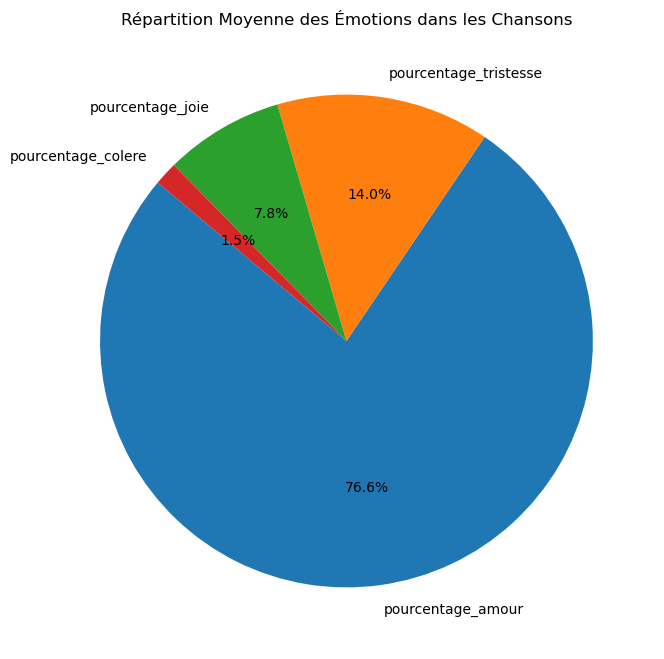

In [11]:
# Calculer les pourcentages moyens pour chaque √©motion
average_percentages = combined_df[['pourcentage_amour', 'pourcentage_tristesse', 'pourcentage_joie', 'pourcentage_colere']].mean()

# Filtrer les √©motions avec un pourcentage de 0
emotion_percentages = average_percentages[average_percentages > 0]

# Noms des √©motions pour les labels du pie chart
emotion_labels = emotion_percentages.index

# Cr√©ation du pie chart
plt.figure(figsize=(8, 8))
plt.pie(emotion_percentages, labels=emotion_labels, autopct='%1.1f%%', startangle=140)
plt.title('R√©partition Moyenne des √âmotions dans les Chansons')
plt.show()

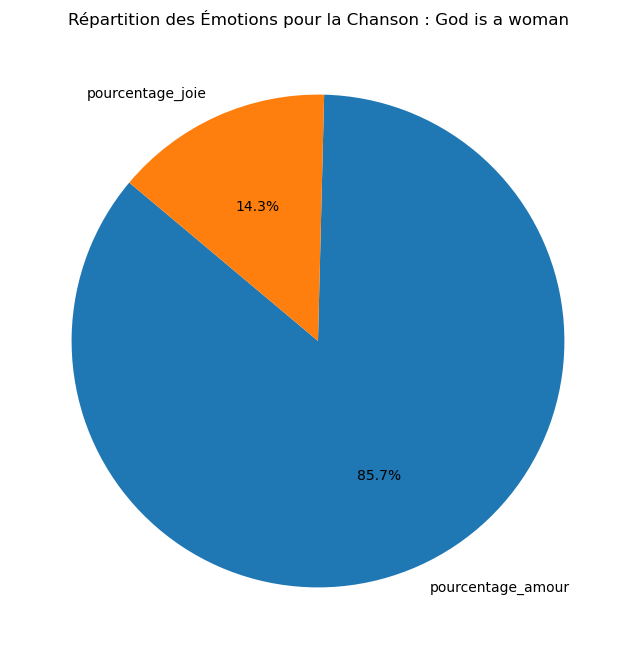

In [12]:
def plot_emotion_distribution(title, df):
    # Trouver la chanson par son titre
    song_data = df[df['Title'] == title]
    
    # V√©rifier si la chanson existe
    if song_data.empty:
        print(f"Aucune chanson trouv√©e avec le titre : {title}")
        return

    # S√©lectionner les pourcentages d'√©motions pour la chanson
    emotion_data = song_data.iloc[0][['pourcentage_amour', 'pourcentage_tristesse', 'pourcentage_joie', 'pourcentage_colere']]
    
    # Filtrer pour exclure les √©motions avec un pourcentage de 0
    emotion_data = emotion_data[emotion_data > 0]

    # Noms des √©motions pour les labels du pie chart
    emotion_labels = emotion_data.index

    # Cr√©ation du pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(emotion_data, labels=emotion_labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"R√©partition des √âmotions pour la Chanson : {title}")
    plt.show()

# Exemple d'utilisation de la fonction
plot_emotion_distribution("‚ÄãGod is a woman", combined_df)

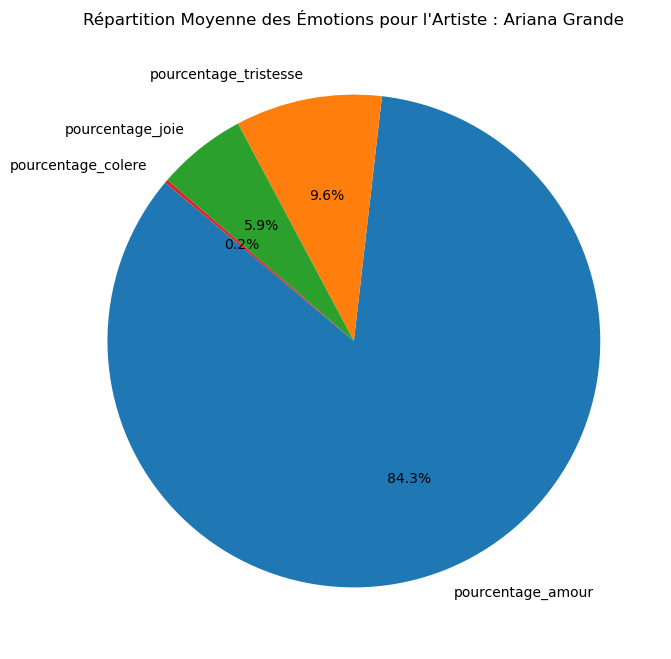

In [13]:
def plot_artist_emotion_distribution(artist_name, df):
    # Filtrer le DataFrame pour l'artiste donn√©
    artist_songs = df[df['Artist'] == artist_name]
    
    # V√©rifier si des chansons de l'artiste existent
    if artist_songs.empty:
        print(f"Aucune chanson trouv√©e pour l'artiste : {artist_name}")
        return

    # Calculer la moyenne des pourcentages d'√©motion pour toutes les chansons de l'artiste
    average_emotion_data = artist_songs[['pourcentage_amour', 'pourcentage_tristesse', 'pourcentage_joie', 'pourcentage_colere']].mean()
    
    # Filtrer pour exclure les √©motions avec un pourcentage de 0
    average_emotion_data = average_emotion_data[average_emotion_data > 0]

    # Noms des √©motions pour les labels du pie chart
    emotion_labels = average_emotion_data.index

    # Cr√©ation du pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(average_emotion_data, labels=emotion_labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"R√©partition Moyenne des √âmotions pour l'Artiste : {artist_name}")
    plt.show()

# Exemple d'utilisation de la fonction
plot_artist_emotion_distribution("Ariana Grande", combined_df)

# On veut faire une repr√©sentation de nos musiques par genre pour prendre les musique similaire a une autre. Faire de l'exploration de titre

In [14]:
import pandas as pd
from textblob import TextBlob
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def sentiment_score(words):
    # Convertir la liste de mots en une cha√Æne de caract√®res
    lyric = ' '.join(words)
    return TextBlob(lyric).sentiment.polarity

# Appliquer la fonction √† votre DataFrame
combined_df['sentiment_score'] = combined_df['Lyric'].apply(sentiment_score)

# Utiliser K-means pour le clustering
# Choisissez un nombre appropri√© de clusters
kmeans = KMeans(n_clusters=5)
combined_df['cluster'] = kmeans.fit_predict(combined_df[['sentiment_score']])


c:\Users\Administrateur\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
import plotly.express as px
import plotly.graph_objs as go
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Cr√©er des vecteurs TF-IDF √† partir des paroles
tfidf = TfidfVectorizer(max_features=100)  # Limiter le nombre de features pour simplifier l'exemple
tfidf_matrix = tfidf.fit_transform(combined_df['Lyric'].apply(lambda x: ' '.join(x)))

# Appliquer TruncatedSVD
svd = TruncatedSVD(n_components=2)
principal_components = svd.fit_transform(tfidf_matrix)
combined_df['feature_x'] = principal_components[:, 0]
combined_df['feature_y'] = principal_components[:, 1]


# Cr√©er un graphique de dispersion avec Plotly
fig = go.Figure()

# Ajouter les points de chaque cluster
for cluster in combined_df['cluster'].unique():
    cluster_data = combined_df[combined_df['cluster'] == cluster]
    fig.add_trace(go.Scatter(
        x=cluster_data['feature_x'],
        y=cluster_data['feature_y'],
        mode='markers',
        marker=dict(size=10),
        name=f'Cluster {cluster}',
        hovertext=cluster_data['Artist'] + ' - ' + cluster_data['Title']
    ))

# Boutons pour choisir le cluster
cluster_buttons = []
for cluster in combined_df['cluster'].unique():
    cluster_buttons.append(
        dict(
            method='update',
            label=f'Cluster {cluster}',
            args=[{'visible': [cluster == c for c in combined_df['cluster'].unique()]}]
        )
    )

# Ajouter un bouton pour montrer tous les clusters
cluster_buttons.append(
    dict(
        method='update',
        label='Tous les clusters',
        args=[{'visible': [True for _ in combined_df['cluster'].unique()]}]
    )
)

# Mise √† jour des layouts avec les boutons
fig.update_layout(
    title='Clusters de Chansons',
    xaxis_title='Caract√©ristique X',
    yaxis_title='Caract√©ristique Y',
    showlegend=True,
    updatemenus=[{"buttons": cluster_buttons, "direction": "down", "showactive": True}]
)

# Afficher le graphique
fig.show()



In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

# Concat√©ner les paroles pour chaque chanson
combined_df['concat_lyrics'] = combined_df['Lyric'].apply(lambda x: ' '.join(x))

# Calculer les vecteurs TF-IDF
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(combined_df['concat_lyrics'])

# Calculer la matrice de similarit√© cosine
similarity_matrix = cosine_similarity(tfidf_matrix)

# # Cr√©er un graphique de r√©seau
# G = nx.Graph()

# # Ajouter des n≈ìuds pour chaque chanson
# for i, row in combined_df.iterrows():
#     G.add_node(i, label=row['Title'])

# # Ajouter des ar√™tes entre les chansons en fonction de leur similarit√©
# for i in range(len(combined_df)):
#     for j in range(i + 1, len(combined_df)):
#         # Vous pouvez ajuster ce seuil selon vos besoins
#         if similarity_matrix[i, j] > 0.5:
#             G.add_edge(i, j, weight=similarity_matrix[i, j])

# # Dessiner le graphique de r√©seau
# plt.figure(figsize=(12, 12))
# pos = nx.spring_layout(G, k=0.5)  # k r√©gule la distance entre les n≈ìuds
# nx.draw_networkx(G, pos, node_size=50, font_size=8)
# plt.title("R√©seau de similarit√© des chansons")
# plt.show()


In [21]:
# Cr√©er un graphe √† partir de la matrice de similarit√©
subset_df = combined_df.sample(100)
tfidf_matrix = tfidf.fit_transform(subset_df['concat_lyrics'])

# Calculer la matrice de similarit√© cosine
similarity_matrix = cosine_similarity(tfidf_matrix)
import networkx as nx
G = nx.Graph()
for i in range(len(similarity_matrix)):
    for j in range(i+1, len(similarity_matrix)):
        # Ajouter une ar√™te si la similarit√© est sup√©rieure √† un seuil
        if similarity_matrix[i, j] > 0.5:  # seuil de similarit√© √† ajuster
            G.add_edge(i, j, weight=similarity_matrix[i, j])

# Position des n≈ìuds dans le graphique
pos = nx.spring_layout(G)

# Cr√©er des traces pour Plotly
edge_trace = go.Scatter(
    x=[], y=[], line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[], y=[], text=[], mode='markers', hoverinfo='text',
    marker=dict(showscale=True, colorscale='Viridis', color=[], size=10))

for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['marker']['color'] += tuple([subset_df['cluster'][node]])
    node_info = f"{subset_df['Artist'][node]} - {subset_df['Title'][node]}"
    node_trace['text'] += tuple([node_info])

# Cr√©er un graphique interactif avec Plotly
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph of song similarity',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()

KeyError: 29